# タスクの概要
このコンペティションの目的は、eコマースのクリック、カートへの追加、および注文を予測することである。

ユーザーセッションの過去のイベントに基づいて、多目的レコメンダーシステムを構築することになります。

現在のレコメンダーシステムは、単純な行列分解から変形型ディープニューラルネットワークまで、アプローチの異なる様々なモデルで構成されています。

しかし、複数の目的を同時に最適化できる単一のモデルは存在しません。

このコンペティションでは、過去の同一セッションのイベントに基づいて、クリックスルー率、カートへの追加率、コンバージョン率を予測する単一エントリーを構築します。

# Imports / setup

In [42]:
import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
from datetime import timedelta
from collections import Counter
from tqdm.notebook import  tqdm
from heapq import nlargest
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

In [43]:
DATA_PATH = Path('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/original')
TRAIN_PATH = DATA_PATH/'train.jsonl'
TEST_PATH = DATA_PATH/'test.jsonl'
SAMPLE_SUB_PATH = Path('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/original/sample_submission.csv')

# Load in the data

In [44]:
# トレーニングデータが何行になるか確認してみましょう。
with open(TRAIN_PATH,'r') as f:
    print(f'we have {len(f.readlines()):,} lines in the training data')

we have 12,899,779 lines in the training data


In [45]:
# サンプルをpandasのdfに読み込む
sample_size = 150000
chunks = pd.read_json(TRAIN_PATH,lines=True,chunksize = sample_size)
for c in chunks:
    sample_train_df = c
    break

In [46]:
sample_train_df.set_index('session',drop=True,inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [64]:
sample_train_df.loc[0].events

[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'},
 {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'},
 {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'},
 {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'},
 {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'},
 {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'},
 {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'},
 {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'},
 {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'},
 {'aid': 362233, 'ts': 1659370064916, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659370067686, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659371003682, 'type': 'clicks'},
 {'aid': 984597, 'ts': 1659371033243, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659371042297, 'type': 'clicks'},
 {'aid': 803544, 'ts': 1659371044075, 'type': 'clicks'},
 {'aid': 1110941, 'ts': 1659371104329, 'type': 'clicks'},
 {'aid': 1190046, 'ts': 

# Data structure
session:一意のセッションIDです。各セッションには、時間順に並んだイベントのリストが含まれます。

events:セッションのイベントの時間順序のシーケンス。各イベントは3つの情報を含む。

* aid:商品id

* ts:タイムスタンプ

* type:イベントの種類（商品がクリックされたか、ユーザーがカートに入れられたか、注文されたか）

In [47]:
# サンプルセッションを見て、基本的な情報を出力してみよう
# dfの最初のセッションをサンプリングする
example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the sesssion: \n {example_session[0]} \n')
# セッションの時間
time_elapsed = example_session[-1]['ts'] - example_session[0]['ts'] #経過時間
# タイムスタンプは1970年1月1日00:00:00 UTCからのミリ秒単位です。
print(f'The first session elapsed:{str(timedelta(milliseconds=time_elapsed))} \n')
# セッション内のアクションの頻度をカウントする
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'],0) + 1
print(f'The first session contains the following frequency of actions:{action_counts}')

This session was 276 actions long 

The first action in the sesssion: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 

The first session elapsed:27 days, 13:09:43.682000 

The first session contains the following frequency of actions:{'clicks': 255, 'carts': 17, 'orders': 4}


# Initial EDA

In [51]:
# 各セッションから情報を抽出し、dfに追加する
action_counts_list,article_id_counts_list,session_length_time_list,session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i ,row in tqdm(sample_train_df.iterrows(),total=len(sample_train_df)):
    actions = row['events']
    # アクションと article_id の頻度を取得する
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'],0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'],0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'],0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'],0) + 1
    # セッションの長さを取得する
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    # リストに加える
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))

sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

In [52]:
overall_action_counts

{'clicks': 7121618, 'carts': 565237, 'orders': 154972}

In [53]:
overall_action_counts.values()

dict_values([7121618, 565237, 154972])

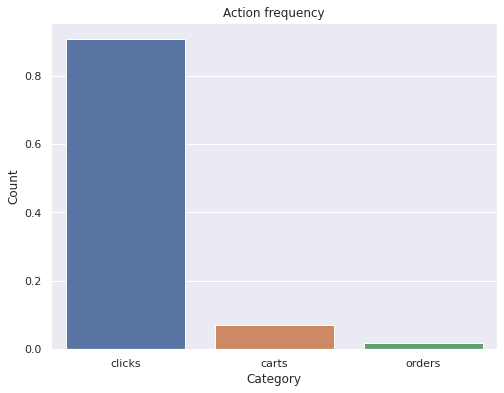

In [57]:
# Actions
total_actions = sum(overall_action_counts.values())
plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()),y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Category',fontsize=12)
plt.show()

Text(0.5, 1.0, 'Length of each session')

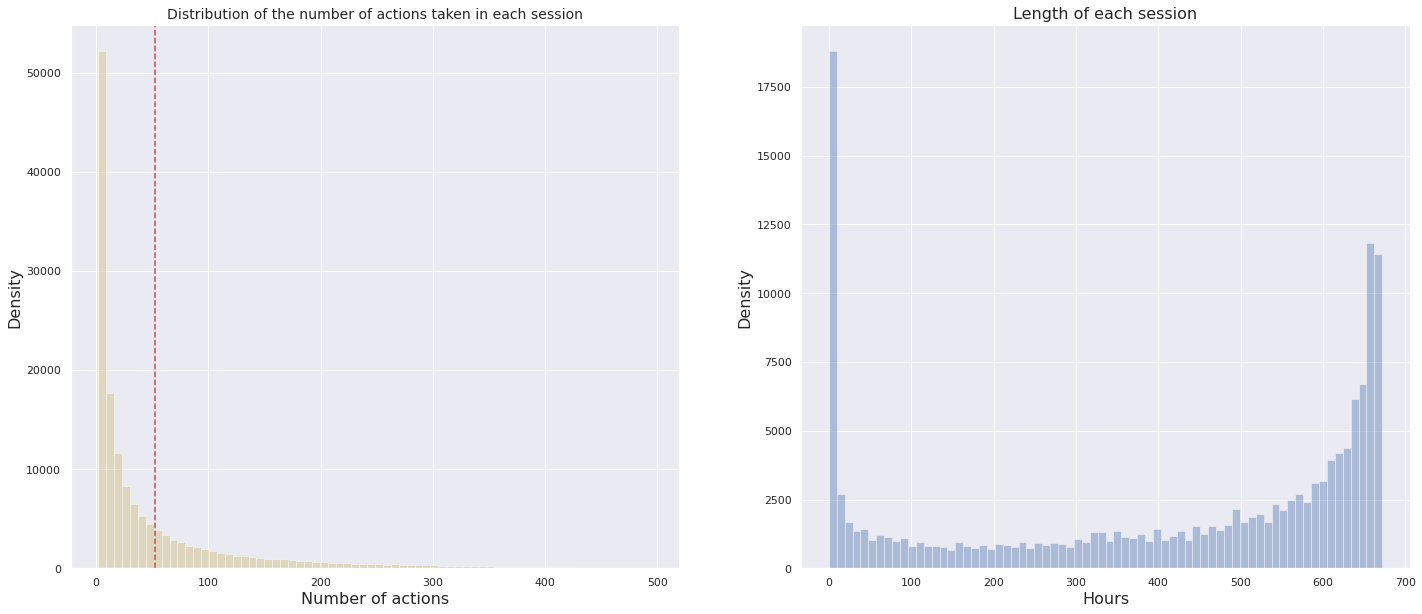

In [58]:
fig,ax = plt.subplots(1,2,figsize=(24,10))
p = sns.distplot(sample_train_df['session_length_action'],color='y',bins=70,ax=ax[0],kde=False)
p.set_xlabel('Number of actions',fontsize=16)
p.set_ylabel('Density',fontsize=16)
p.set_title('Distribution of the number of actions taken in each session',fontsize=14)
p.axvline(sample_train_df['session_length_action'].mean(),color='r',linestyle='--',label='Mean')

p = sns.distplot(sample_train_df['session_length_hours'],color='b',bins=70,ax=ax[1],kde=False)
p.set_xlabel('Hours',fontsize=16)
p.set_ylabel('Density',fontsize=16)
p.set_title('Length of each session',fontsize=16)

すべてのセッションの上限が650時間になっているのはおかしい

In [59]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


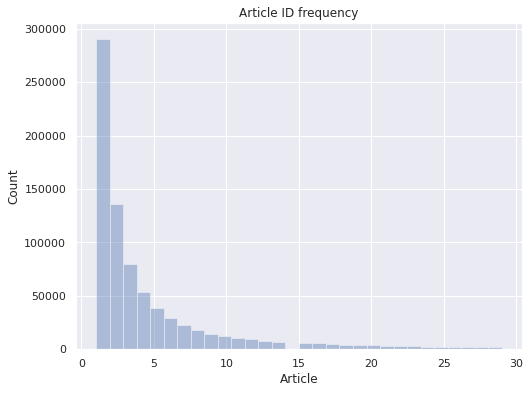

In [60]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

上のプロットからわかるように、大半のArticleは、それらに関連するアクションの数が非常に少なくなっています。例外もありますが...。

In [61]:
# 最もアクセス数の多いarticleを見てみる
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


# Baseline
テストデータには、学習データと同様にセッション
が切り捨てられたデータが含まれている。

タスクは、セッションの切り捨て後にclicksされた次のaidと、cartsやordersに追加された残りのaidを予測することである。

提出されたものは、各アクションタイプのRecallで評価され、3つのRecall値は重み付け平均される。{clicks': 0.10, 'carts': 0.30、'orders': 0.60} 

ordersの予測は、重みの大部分を占めるので、正しく行うことが重要です

テストデータの各セッションについて、あなたのタスクは、テストセッションの最後のタイムスタンプの後に発生する各タイプのaidを予測することです。

言い換えれば、テストデータにはタイムスタンプで切り捨てられたセッションが含まれており、切り捨てられた時点以降に発生するものを予測することになります。

clicksについては、各セッションのグランドトゥルース値は1つだけで、それはセッション中にクリックされた次のaidです（ただし、最大20aidまで予測することができます）。

cartsとordersのグランドトゥルースは、セッション中にそれぞれカートに追加され、注文されたすべてのaidを含んでいます。

各セッションとタイプの組み合わせは、提出物の中でそれ自身の session_type 行に表示される必要があり（セッションごとに 3 行）、予測はスペースで区切られる必要があります。これは、以下の sample_test_df で見ることができます。

In [65]:
with open(TEST_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the test data")

We have 1,671,803 lines in the test data


In [66]:
# サンプルをdfに読み込む
sample_size = 150
chunks = pd.read_json(TEST_PATH, lines=True, chunksize = sample_size)
for c in chunks:
    sample_test_df = c
    break

以下は、提出されたサンプルです。

テストセット内の各セッションには、予測（ラベル）があります。

これは、そのセッションで次にどのarticleがインタラクションされるかを予測するものである。

各セッションには3つのアクション（クリック、カート、注文）があり、予測は3つのアクションすべてに対して行われます。

In [68]:
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)
sample_submission.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


各アクションの種類ごとに、最も一般的なarticleを検索してみましょう。

In [69]:
sample_size = 150000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

clicks_article_list = []
carts_article_list = []
orders_article_list = []

for e, c in enumerate(chunks):
    
    # Save time by not using all the data
    if e > 2:
        break
    
    sample_train_df = c
    
    for i, row in c.iterrows():
        actions = row['events']
        for action in actions:
            if action['type'] == 'clicks':
                clicks_article_list.append(action['aid'])
            elif action['type'] == 'carts':
                carts_article_list.append(action['aid'])
            else:
                orders_article_list.append(action['aid'])

In [70]:
# articleとその頻度から辞書を作成する
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [71]:
# 各アクションで最も頻度の高い20のarticleを取得する
top_click_article = nlargest(20, article_click_freq, key = article_click_freq.get)
top_carts_article = nlargest(20, article_carts_freq, key = article_carts_freq.get)
top_order_article = nlargest(20, article_order_freq, key = article_order_freq.get) 

In [72]:
# この情報を元に辞書を作成する
frequent_articles = {'clicks': top_click_article, 'carts':top_carts_article, 'order':top_order_article}

In [73]:
for action in ['clicks', 'carts', 'order']:
    print(f'Most frequent articles for {action}: {frequent_articles[action][:5]}')

Most frequent articles for clicks: [29735, 1733943, 108125, 1603001, 832192]
Most frequent articles for carts: [80222, 29735, 1733943, 166037, 485256]
Most frequent articles for order: [80222, 166037, 1022566, 351335, 1629608]


いくつかの重複がありますが、異なるアクションのためにarticleは変化します。

このベースラインは、人々が以前にやりとりしたarticleとやりとりすることが多いという事実を利用します。

予測はセッションで最も頻繁に使われるトップ20のarticleで構成されます。

もしセッションに20個以下の記事がある場合、予測は上記のようにトレーニングデータで最も頻度の高い記事で埋め合わせをする。

In [74]:
test_data = pd.read_json(TEST_PATH, lines=True, chunksize=1000)

preds = []

for chunk in tqdm(test_data, total=1671):
    
    for i, row in chunk.iterrows():
        actions = row['events']
        article_id_list = []
        for action in actions:
            article_id_list.append(action['aid'])
            
        # Get 20 most common article ID for the session
        article_freq = Counter(article_id_list)
        top_articles = nlargest(20, article_freq, key = article_freq.get)
        
        # Pad with most popular items in training
        padding_size = (20 - len(top_articles)) # Correction by @danielliao 🙏
        for action in ['clicks', 'carts', 'order']:
            top_articles_added = top_articles + frequent_articles[action][:padding_size] # Correction by @danielliao 🙏
            preds.append(" ".join([str(id) for id in top_articles_added]))

  0%|          | 0/1671 [00:00<?, ?it/s]

In [75]:
# 各テストセッションで最も多い20のarticleを予測する
sample_submission['labels'] = preds

In [76]:
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/submission/getting_started.csv', index=False)
sample_submission.to_csv('getting_started.csv', index=False)

In [77]:
!pip install kaggle -q
import os
import json
f = open("/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [78]:
!kaggle competitions submit -c otto-recommender-system -f getting_started.csv -m ""

100% 770M/770M [00:28<00:00, 28.2MB/s]
Successfully submitted to OTTO – Multi-Objective Recommender System

# next
今のところ、私たちはすべての予測に同じ最も頻繁に出現するarticleを入れています。

同じセッションでどのarticleが頻繁に共起するかを調べれば、モデルは改善されるだろう（KJとVLADIMIR SLAYKOVSKIYはこれを調べ始めている）。

ショッピングでは、クリック -> カート -> 注文という一連のイベントがあります。現在、それぞれのアクションでどの記事が最も多いかを調べていますが、確かに最も注文されやすいのは、すでにカートに入っている商品でしょう。